In [47]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models,callbacks, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
images=[]
labels=[]

In [3]:
os.chdir('/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images')

In [4]:
os.listdir()

['Mild', 'Proliferate_DR', 'Moderate', 'No_DR', 'Severe']

In [5]:
dir_names=os.listdir()

In [6]:
import cv2
for dir_name in dir_names:
    os.chdir(f'./{dir_name}')
    for img_path in os.listdir():
        if img_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):  # Add more image formats if necessary
            img_full_path = os.path.join(os.getcwd(), img_path)  # Get full path to the image
            img = cv2.imread(img_full_path)
            images.append(img)
            labels.append(dir_name)
    os.chdir('..')

In [7]:
images=np.array(images)
labels=np.array(labels)

<Axes: ylabel='count'>

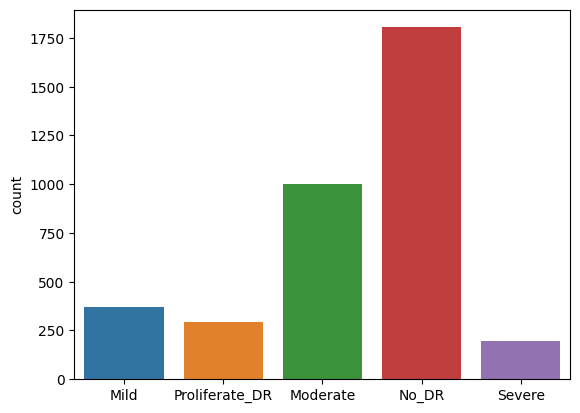

In [8]:
sns.countplot(x=labels)

In [9]:
labels = (labels != 'No_DR' ).astype(int)

<Axes: ylabel='count'>

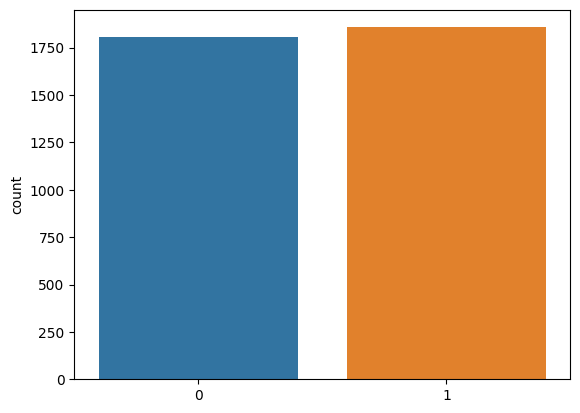

In [10]:
sns.countplot(x=labels)

In [11]:
len(images),len(labels)

(3662, 3662)

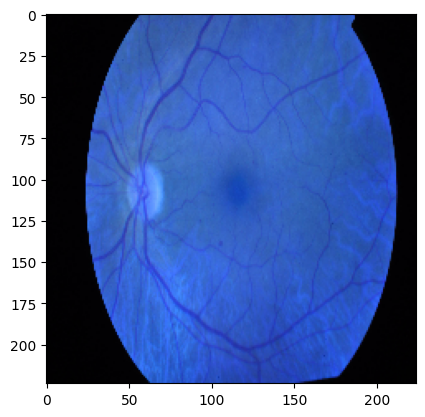

In [12]:
img=images[256]
plt.imshow(img)

In [13]:
def preprocess_image(image):
#     Convert image to grayscale
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
#     # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     clahe_image = clahe.apply(gray_image)
    
#     # Apply Gaussian blur to reduce noise
#     blurred_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)
    
#     # Apply Canny edge detection
#     edges = cv2.Canny(blurred_image, threshold1=30, threshold2=100)
    img_ben = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), 10), -3.5, 80)
    img_ben=img_ben/255
    return img_ben

In [14]:
preprocessed_image=preprocess_image(img)

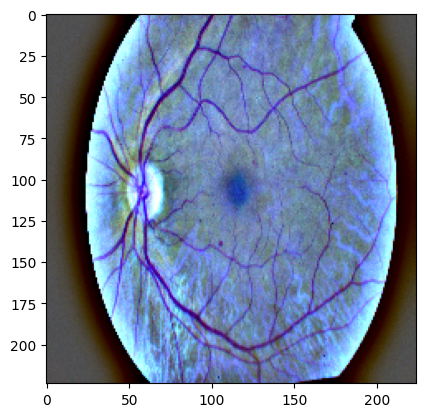

In [15]:
plt.imshow(preprocessed_image)

In [16]:
preprocessed_images=[preprocess_image(img) for img in images]
preprocessed_images=np.array(preprocessed_images)

In [32]:
def LeNet5(input_shape, dropout_rate=0.25, l2_reg=0.01):
    model = models.Sequential()

    # Layer 1: Convolutional layer with 6 filters, kernel size 5x5, and ReLU activation
    model.add(layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))

    # Layer 2: Average pooling layer with kernel size 2x2
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(dropout_rate))

    # Layer 3: Convolutional layer with 16 filters, kernel size 5x5, and ReLU activation
    model.add(layers.Conv2D(16, kernel_size=(5, 5), activation='relu'))

    # Layer 4: Average pooling layer with kernel size 2x2
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(dropout_rate))

    # Layer 5: Flatten layer
    model.add(layers.Flatten())

    # Layer 6: Fully connected layer with 120 neurons and ReLU activation
    model.add(layers.Dense(120, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.Dropout(dropout_rate))

    # Layer 7: Fully connected layer with 84 neurons and ReLU activation
    model.add(layers.Dense(84, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.Dropout(dropout_rate))

    # Output layer: Fully connected layer with 1 neuron and sigmoid activation
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [33]:
input_shape = (224, 224, 3)  # Example input shape for CIFAR-10 dataset

In [34]:
model = LeNet5(input_shape)

In [51]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 220, 220, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 106, 106, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 44944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 120)            │     5,393,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,219,565 (61.87 MB)

 Trainable params: 5,406,521 (20.62 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,813,044 (41.25 MB)

In [35]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [36]:
x_train,x_test,y_train,y_test=train_test_split(preprocessed_images,labels,stratify=labels,random_state=404,shuffle=True,test_size=.2)

In [37]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [38]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping],shuffle=True)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.7154 - loss: 3.1697 - val_accuracy: 0.9209 - val_loss: 1.0235
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9190 - loss: 0.8609 - val_accuracy: 0.9195 - val_loss: 0.6091
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9211 - loss: 0.5959 - val_accuracy: 0.9263 - val_loss: 0.5338
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9260 - loss: 0.5203 - val_accuracy: 0.9318 - val_loss: 0.5360
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9323 - loss: 0.4819 - val_accuracy: 0.9386 - val_loss: 0.4284
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9151 - loss: 0.4745 - val_accuracy: 0.9345 - val_loss: 0.4044
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9213 - loss: 0.4386 - val_accuracy: 0.9318 - val_loss: 0.3745
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9305 - loss: 0.3808 - val_accuracy: 

In [39]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


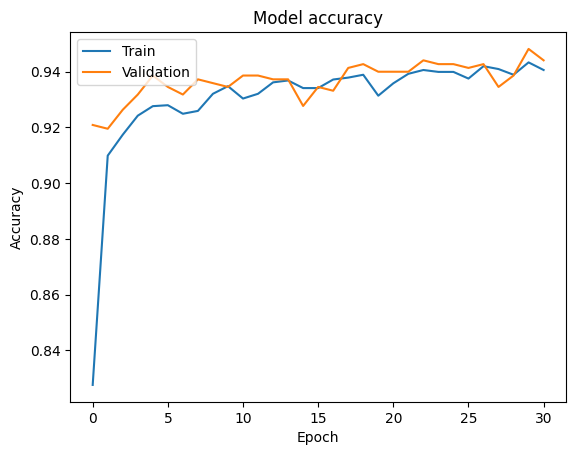

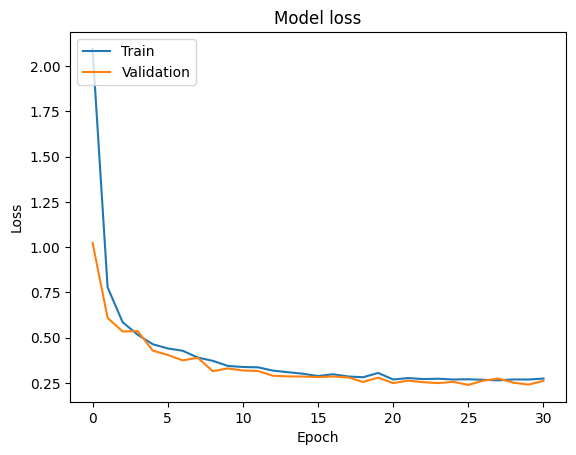

In [40]:
plot_history(history)

In [44]:
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


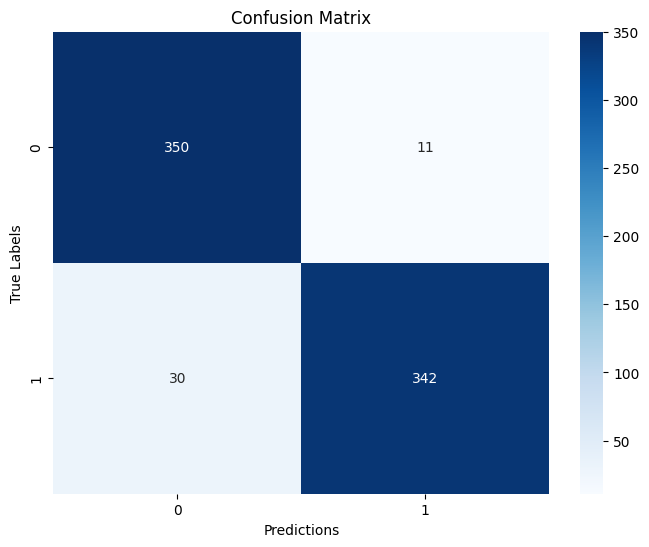

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("True Labels")
plt.show()

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       361
           1       0.97      0.92      0.94       372

    accuracy                           0.94       733
   macro avg       0.94      0.94      0.94       733
weighted avg       0.95      0.94      0.94       733



In [50]:
model.save('/kaggle/working/binary_classifier.h5')